# CLIMATE DATA DE BILT 

Bu notebook, Hollanda'daki 1800-2014 yılları arasındaki iklim normallerinin kaydedildiği bir veri seti kullanılarak iklim verilerinin birbiriyle ilişkisini analiz etmek ve bir tahmin modeli gelistirmek amacıyla **veri işleme** ve **Python uygulamaları** üzerine bir çalışma içermektedir.

##### Bu notebook spesifik olarak Data Preprocessing kısmına yoğunlaşmaktadır. Data Analysis ve diğer adımlar başka notebooklarda yapılacaktır.

In [3]:
import pandas as pd
import requests
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [7]:
# Excel dosyasını içe aktarma
file_path = "veri.xlsx"
df = pd.read_excel(file_path)

In [9]:
#Veri setimin boyutunu (satır, sütun) olarak kontrol ediyorum.

print(df.shape)

(217, 21)


In [11]:
#Data setimin içindeki veri tiplerini görmek istiyorum

df.dtypes

ID                                     int64
Periods                               object
YearAverage_1                        float64
WinterAverage_2                      float64
SummerAverage_3                      float64
WinterAverageMinimumTemperature_4    float64
SummerAverageMaximumTemperature_5    float64
IceDays_6                            float64
FrostDays_7                          float64
SummeryDays_8                        float64
TropicalDays_9                       float64
HeatingDegreeDays_10                 float64
QuantityOfPrecipitation_11           float64
DaysWithPrecipitation_12             float64
SnowDays_13                          float64
DryDays_14                           float64
DaysWithFog_15                       float64
Evaporation_16                       float64
RelativeHumidity_17                  float64
HoursOfSunshine_18                   float64
SunlessDays_19                       float64
dtype: object

In [13]:
#Ilk 5 satırı görmek istiyorum

print(df.head())

   ID   Periods  YearAverage_1  WinterAverage_2  SummerAverage_3  \
0   0  1971X000            9.8              3.3             16.6   
1   1  1981X000           10.1              3.4             17.0   
2   2  1800JJ00            NaN             -1.0             15.1   
3   3  1801JJ00            NaN              1.7             15.2   
4   4  1802JJ00            NaN              1.1             15.3   

   WinterAverageMinimumTemperature_4  SummerAverageMaximumTemperature_5  \
0                                0.4                               21.4   
1                                0.5                               21.9   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   

   IceDays_6  FrostDays_7  SummeryDays_8  ...  HeatingDegreeDays_10  \
0        8.0         58.0           22.0  ...                3075.0  

In [15]:
#NaN şeklinde gösterilen kısımlar eksik veri. Veri setimde her sütunda toplam kaç eksik veri olduğunu kontrol ediyorum.

print(df.isnull().sum())

ID                                     0
Periods                                0
YearAverage_1                        100
WinterAverage_2                        0
SummerAverage_3                        0
WinterAverageMinimumTemperature_4    180
SummerAverageMaximumTemperature_5    180
IceDays_6                            151
FrostDays_7                          151
SummeryDays_8                        151
TropicalDays_9                       180
HeatingDegreeDays_10                 140
QuantityOfPrecipitation_11           106
DaysWithPrecipitation_12             171
SnowDays_13                          180
DryDays_14                           181
DaysWithFog_15                       180
Evaporation_16                       180
RelativeHumidity_17                  180
HoursOfSunshine_18                   100
SunlessDays_19                       171
dtype: int64


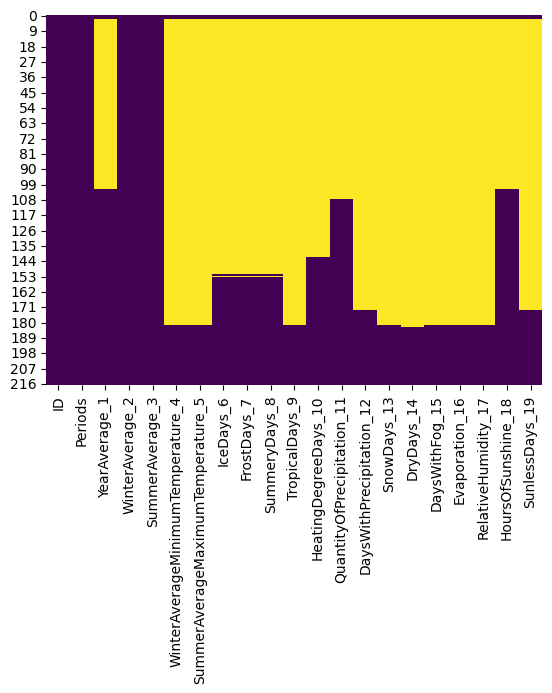

In [17]:
# Eksik verileri görselleştirmek için ısı haritası kullanıyorum.

import seaborn as sns

sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

YORUMLAR

Veri setini aldığımız sitedeki açıklamaya göre ve [17] numaralı hücrede gördüğümüz üzere şu sonuçlara varmaktayız:

1. 1800 yılından 2014 yılına kadar verilerin toplandığı bu veri setinde toplam 214+2 = 216 yıl için iklim verisi girilmiş.

a) Winter Average Temperature ve Summer Average Temperature verileri 1800 yılından başlamakta. Tüm sütunlar dolu.

b) Yearly Average Temperature ve Hours of Sunshine verilerinin ilk 99 sütunu boş. Veriler 1900 yılından itibaren başlamakta.

c) Gün bazında veriler çoğunluk olarak 1940 ve 1950 yılından itibaren başlamakta.

d) Tümüyle tamamlanmış veriler 1980 ve sonrasına ait.

2. Data setindeki veriler: 4 ana başlığa dağılıyor:

a) Sıcaklık bazında veriler: Yearly Avg Temp, Winter Avg Temp, Summer Avg Temp, Winter Avg Min Temp ve Summer Avg Max Temp.

b) Gün bazında veriler: Ice Days, Frost Days, Summery Days, Tropical Days, Snow Days, Heating Degree Days, Days with Precipitation, Days with Fog, Dry Days, Sunless Days

c) Saat bazında veriler: Hours of Sunshine

d) Diğer: Quantity of Precipitation (Birimi bilinmiyor/mm,cm,lt per sqm olabilir), Evaporation (Birimi bilinmiyor), Relative Humidity (%)

Verilerin yıllara göre dağılımını daha iyi anlayabilmek adına filtreleme kullanılabilir. Birinci filtreleme eksik veri sayısı bazında olmalı. Ikinci filtreleme tür bazında olabilir. Böylelikle değişkenlerin kendi içlerindeki korelasyonunu daha iyi gözlemleyebiliriz.

3. Periods değişkeninin türü object olarak nitelendirilmiş. Ancak bu değişken aslında yılları belirtiyor.

Periods değişkeninin içeriği, '1971X000' gibi bir formata sahip. Bu değerin yıl kısmının alınıp diğer kısmın temizlenmesi için düzenleme yapılması gerekmekte. Bu durumda yıl kısmını almak için metin dilimleme (str slicing) kullanılacak.

4. ID değişkeni veri sırasını belirtiyor.

ID değişkeni sadece verilerin sırasını belirtiyor ve veri setine aslında bir katkı sağlamamakta. Bu tür gereksiz sütunlar, modelleme ve analiz aşamalarında karmaşıklığı artırabilir ve verinin okunabilirliğini azaltabilir. Bu değişken veri setinden kaldırılacak.

### SONUÇ:

1. Veri setindeki girdisi olmayan veriler temizlenecek.
2. Periods değişkeninin türünü düzeltilecek ve ID değişkenini silinecek.
3. Diğer değişkenlerin isimleri daha sonra karışıklığa sebep olmasın diye VeriTürü_Sayı formatı kaldırılacak ve isimleri daha açıklayıcı bir şekilde güncellenecek. Örn: YearAverage_1 değişkeninin ismi Year_Average_Temperature olarak değiştirilecek.

## DATA PREPROCESSING

### 1. Adım: ID değişkenini temizleme

In [22]:
# 'ID' sütununu veri setinden kaldırma
df.drop(columns=['ID'], inplace=True)

# Değişiklikleri kontrol ediyoruz
print(df.head())

    Periods  YearAverage_1  WinterAverage_2  SummerAverage_3  \
0  1971X000            9.8              3.3             16.6   
1  1981X000           10.1              3.4             17.0   
2  1800JJ00            NaN             -1.0             15.1   
3  1801JJ00            NaN              1.7             15.2   
4  1802JJ00            NaN              1.1             15.3   

   WinterAverageMinimumTemperature_4  SummerAverageMaximumTemperature_5  \
0                                0.4                               21.4   
1                                0.5                               21.9   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   

   IceDays_6  FrostDays_7  SummeryDays_8  TropicalDays_9  \
0        8.0         58.0           22.0             3.0   
1        8.0         58.0           26.0    

In [24]:
# Veri setinin yeni boyutunu (satır, sütun) olarak kontrol ediyoruz.

print(df.shape)

(217, 20)


### 2. Adım: Periods değişkeni - Metin dilimleme (String Slicing)

In [27]:
# Periods değişkeninin ilk 4 karakterini alarak yılı çek. Yeni değişken için "Year" ismini kullan.  

df['Year'] = df['Periods'].str[:4].astype(int)

df.drop('Periods', axis=1, inplace=True)

#Yeni 'Year' değişkenini kontrol et.

print(df['Year'].head())

0    1971
1    1981
2    1800
3    1801
4    1802
Name: Year, dtype: int64


In [29]:
#Data setimin içindeki tüm veri tiplerini tekrar kontrol ediyorum 

df.dtypes

YearAverage_1                        float64
WinterAverage_2                      float64
SummerAverage_3                      float64
WinterAverageMinimumTemperature_4    float64
SummerAverageMaximumTemperature_5    float64
IceDays_6                            float64
FrostDays_7                          float64
SummeryDays_8                        float64
TropicalDays_9                       float64
HeatingDegreeDays_10                 float64
QuantityOfPrecipitation_11           float64
DaysWithPrecipitation_12             float64
SnowDays_13                          float64
DryDays_14                           float64
DaysWithFog_15                       float64
Evaporation_16                       float64
RelativeHumidity_17                  float64
HoursOfSunshine_18                   float64
SunlessDays_19                       float64
Year                                   int64
dtype: object

### 3. Adım: Değişkenlerin isimlerini değiştirme

In [33]:
# Sütunların adını değiştirme
df.rename(columns={'YearAverage_1': 'YearlyAvgTemp','WinterAverage_2': 'WinterAvgTemp','SummerAverage_3': 'SummerAvgTemp','WinterAverageMinimumTemperature_4': 'WinterAvgMinTemp','SummerAverageMaximumTemperature_5': 'SummerAvgMaxTemp','IceDays_6':'IceDays','FrostDays_7':'FrostDays','SummeryDays_8':'SummeryDays','TropicalDays_9':'TropicalDays','HeatingDegreeDays_10':'HeatingDegreeDays','QuantityOfPrecipitation_11':'QuantityOfPrecipitation','DaysWithPrecipitation_12':'DaysWithPrecipitation','SnowDays_13':'SnowDays','DryDays_14':'DryDays','DaysWithFog_15':'DaysWithFog','Evaporation_16':'Evaporation','RelativeHumidity_17':'RelativeHumidity','HoursOfSunshine_18':'HoursOfSunshine','SunlessDays_19':'SunlessDays'}, inplace=True)

# Değişikliğin doğruluğunu kontrol etmek için sütun adlarını görüntülüyoruz
print(df.columns)

Index(['YearlyAvgTemp', 'WinterAvgTemp', 'SummerAvgTemp', 'WinterAvgMinTemp',
       'SummerAvgMaxTemp', 'IceDays', 'FrostDays', 'SummeryDays',
       'TropicalDays', 'HeatingDegreeDays', 'QuantityOfPrecipitation',
       'DaysWithPrecipitation', 'SnowDays', 'DryDays', 'DaysWithFog',
       'Evaporation', 'RelativeHumidity', 'HoursOfSunshine', 'SunlessDays',
       'Year'],
      dtype='object')


### 4. Adım: Değişkenlerin açıklanması ve kategorize edilmesi

#### Sıcaklık Bazındaki Değişkenler

Yearly Average Temperature: Yıllık ortalama sıcaklık verisi

Winter Average Temperature: Kış mevsimi ortalama sıcaklık verisi

Summer Average Temperature: Yaz mevsimi ortalama sıcaklık verisi

Winter Average Minimum Temperature: Kış mevsimi ortalama minimum sıcaklık verisi

Summer Average Temperature: Yaz mevsimi ortalama maximum sıcaklık verisi

#### Zaman (Gün, saat) Bazındaki Değişkenler

Bu değişkenler Hollanda ikliminin (sık yağışlı, serin ve yüksek nemli) karakteristiği dolayısıyla hava olaylarının sıklığı ve gelişme sırası göz önünde bulundurularak sıralandırılmıştır. 

Sunless Days: Güneş ışığının olmadığı, bulutlu ve kapalı havanın hakim olduğu günler. Yağışı tetikler.

Days with Precipitation: Yağışlı günler. 

Days with Fog: Nemli ve genellikle soğuk hava koşullarında oluşan sisli günler. Yağış sonrasında veya beraberinde görülebilir. 

Ice Days: Buzlu günler. Gündüz sıcaklıklarının sıfırın altına düştüğü günler.

Frost Days: Donlu günler. Gece sıcaklıklarının sıfırın altına düştüğü günler. Buzlu günler ile örtüşebilir, gece soğukluğu daha belirgindir.

Snow Days: Kar yağışı olan günler. Genellikle buzlu ve donlu günlerden sonra ya da bu günlerle birlikte görülebilir. 

Hours of Sunshine: Güneşli saatler. Günün sıcaklığı ile ilgili bir gösterge olabilir ancak doğrudan bir 'sıcak gün' tanımı oluşturmaz. Güneşin gün içerisinde ne kadar göründüğünü belirtir. 

Summery Days: Sıcak günler.

Tropical Days: Aşırı sıcak ve nemli günler.

Dry Days: Kurak, yağışsız havanın hakim olduğu günler.

#### Diğer kategorideki değişkenler

Relative Humidity (%): Bağıl Nem. Havanın ne kadar su buharı taşıdığını ve yağış olasılığını gösterir.

Quantiy of Precipitation: Yağış miktarı. Bağıl nemin yüksekliği ile doğrudan ilişkili. Bu veri setindeki birimi bilinmiyor.

Evaporation: Buharlaşma oranı. Nem ve yağış oranı ile ters orantılıdır. Eğer hava nemliyse, buharlaşma oranı düşer çünkü hava zaten su buharına doygundur. 

#### Gün-Derece (Degree Days)

Gün derece (Degree Days): Binaların ısıtma veya soğutma ihtiyacını ölçmek için kullanılan bir ölçüm. Hava sıcaklıklarının referans sıcaklıktan ne kadar saptığını gösterir.

Heating Degree Days: Isıtma gün derecesi. Sıcaklıklar referans sıcaklığın altında olduğunda, mekanların ısıtılması gerektiğini gösterir.

Cooling Degree Days: Soğutma gün derecesi. Sıcaklıklar referans sıcaklığın üstünde olduğunda, mekanların soğutulması gerektiğini gösterir.

##### Not: Bu veri setinde Cooling Degree Days değişkeni yok. Daha sonraki adımlarda bu veri eklenmesi olası. 


### 5. Adım: Değişkenlerin sıralamasını değiştirme

Veri setindeki değişkenlerin yerleri 4. Adımdaki bağlamlar referans alınarak değiştirilecek. 

Böylelikle değişkenler arası ilişkiler daha rahat gözlemlenebilir. 

In [42]:
# Sütunları yeniden sıralama:
df = df[["Year", "YearlyAvgTemp", "WinterAvgTemp", "WinterAvgMinTemp", "SummerAvgTemp", "SummerAvgMaxTemp", "SunlessDays", "DaysWithPrecipitation", "DaysWithFog", "IceDays", "FrostDays", "SnowDays", "HoursOfSunshine", "SummeryDays", "TropicalDays", "DryDays", "RelativeHumidity", "QuantityOfPrecipitation", "Evaporation", "HeatingDegreeDays"]]

# Yeni DataFrame'i görüntüle
print(df)

     Year  YearlyAvgTemp  WinterAvgTemp  WinterAvgMinTemp  SummerAvgTemp  \
0    1971            9.8            3.3               0.4           16.6   
1    1981           10.1            3.4               0.5           17.0   
2    1800            NaN           -1.0               NaN           15.1   
3    1801            NaN            1.7               NaN           15.2   
4    1802            NaN            1.1               NaN           15.3   
..    ...            ...            ...               ...            ...   
212  2010            9.1            1.1              -1.5           17.7   
213  2011           10.9            2.3              -0.5           16.3   
214  2012           10.3            4.1               1.1           16.9   
215  2013            9.8            2.9               0.4           17.5   
216  2014           11.7            6.0               3.3           17.4   

     SummerAvgMaxTemp  SunlessDays  DaysWithPrecipitation  DaysWithFog  \
0            

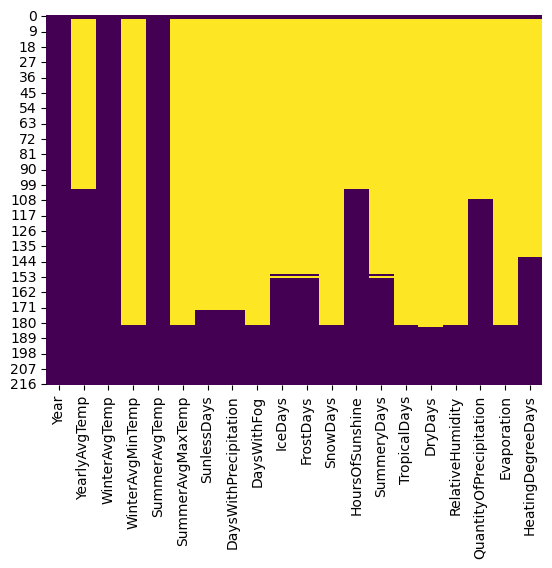

In [44]:
# Eksik verileri görselleştirmek için tekrar ısı haritası kullanıyorum.

sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

#### 6. Adım: Eksik ve yanıltıcı verilerin silinmesi

Yukarıdaki ısı haritasında; mor renkler ile verilerin olduğu satır ve sütunlar, sarı renkler ile verilerin olmadığı (NaN) satır ve sütunlar gösterilmekte. Verilerin olmadığı satırları kaldırmak gerekmekte. 


    Isı haritasında görüldüğü üzere en az verisi girilmiş değişken Dry Days değişkeni. Dry Days değişkeni için ilk veri girdisi 180. satır sonrası girilmiş duruyor. 180. satır ve sonrasını yazdırarak veri girişinin tam olarak hangi yılda başladığını bulabiliriz.

In [69]:
# Satır numaralarını bir liste olarak belirleyin
satir_numaralari = [172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184] 

# Belirtilen satırları görüntülemek için iloc kullanıyorum
secilen_satirlar = df.iloc[satir_numaralari]

# Seçilen satırları yazdırıyorum 
print(secilen_satirlar)

     Year  YearlyAvgTemp  WinterAvgTemp  WinterAvgMinTemp  SummerAvgTemp  \
172  1970            9.1            0.1               NaN           16.7   
173  1971            9.5            2.8               NaN           16.1   
174  1972            8.8            3.2               NaN           15.4   
175  1973            9.3            3.0               NaN           16.9   
176  1974            9.7            4.2               NaN           15.5   
177  1975            9.8            5.5               NaN           17.6   
178  1976           10.0            3.5               NaN           18.4   
179  1977            9.8            3.2               NaN           15.9   
180  1978            9.0            3.0               NaN           15.2   
181  1979            8.5           -0.8               NaN           15.5   
182  1980            9.3            3.5               0.8           15.9   
183  1981            9.2            2.6              -0.2           15.8   
184  1982   

    Dry Days değişkeni için ilk veri girdisi 183. satırda yani 1981 yılında yapılmış. Önceki senelere ait verileri silebiliriz. 


In [72]:
# 1981 ve sonrasındaki verileri tutup, 1981'den önceki verileri siliyorum
df = df[df['Year'] >= 1981]

# İndeksleri sıfırlayın
df.reset_index(drop=True, inplace=True)


# Yeni DataFrame'i görüntülüyorum
print(df)

    Year  YearlyAvgTemp  WinterAvgTemp  WinterAvgMinTemp  SummerAvgTemp  \
0   1981           10.1            3.4               0.5           17.0   
1   1981            9.2            2.6              -0.2           15.8   
2   1982           10.1            1.1              -2.1           17.6   
3   1983           10.1            3.5               0.7           18.2   
4   1984            9.5            3.1               0.4           15.9   
5   1985            8.5            0.2              -3.2           15.7   
6   1986            9.0            1.5              -1.4           16.4   
7   1987            8.9            1.5              -1.4           15.6   
8   1988           10.3            5.0               2.3           15.8   
9   1989           10.7            5.6               2.8           17.0   
10  1990           10.9            6.0               3.2           16.8   
11  1991            9.5            2.2              -0.9           16.6   
12  1992           10.5  

In [74]:
#Yeni veri setimin boyutunu (satır, sütun) olarak kontrol ediyorum.

print(df.shape)

(35, 20)


In [76]:
# Veri çerçevesindeki eksik veri olup olmadığını kontrol ediyorum
missing_data = df.isnull().sum()

# Sonuçları görüntülüyorum
print(missing_data)

Year                       0
YearlyAvgTemp              0
WinterAvgTemp              0
WinterAvgMinTemp           0
SummerAvgTemp              0
SummerAvgMaxTemp           0
SunlessDays                0
DaysWithPrecipitation      0
DaysWithFog                0
IceDays                    0
FrostDays                  0
SnowDays                   0
HoursOfSunshine            0
SummeryDays                0
TropicalDays               0
DryDays                    0
RelativeHumidity           0
QuantityOfPrecipitation    0
Evaporation                0
HeatingDegreeDays          0
dtype: int64


    Bundan sonraki adımlarda, Veri Analizi ve Tahmin Modeli Geliştireceğim. Ancak bu adımları farklı notebooklarda izleyeceğim. Dolayısıyla temizlenmiş mevcut veri setimi bu adımda kaydedeceğim. 

In [80]:
# Yeni dosyaya kaydetmek (Excel formatında)
df.to_excel('ClimateDeBilt_Preprocessed.xlsx', index=False)  # index=False, indeks sütununu dahil etmemek için


## - Data Preprocessing Sonu - 